In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge  # Changed from LinearRegression to Ridge
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

# Set plot style
plt.style.use('ggplot')

In [2]:
# --- 1. Load Raw Data with Corrected Paths ---
# Using ../../ as requested to go back two folders to RAW_DATA
try:
    path_cases = '../../RAW_DATA/Virus/Covid_19/covid_19_india/covid_19_india.csv'
    path_vaccine = '../../RAW_DATA/Virus/Covid_19/covid_19_india/covid_vaccine_statewise.csv'
    path_testing = '../../RAW_DATA/Virus/Covid_19/covid_19_india/StatewiseTestingDetails.csv'

    df_india = pd.read_csv(path_cases)
    df_vaccine = pd.read_csv(path_vaccine)
    df_testing = pd.read_csv(path_testing)
    
    print("Files loaded successfully.")
    
except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    # Fallback for debugging if paths are slightly different in your local env
    print("Please check that the notebook is in 'Practice_models/polynomial_regression/'")

# --- 2. Date Formatting ---
df_india['Date'] = pd.to_datetime(df_india['Date'], format='%Y-%m-%d')
df_vaccine['Date'] = pd.to_datetime(df_vaccine['Updated On'], dayfirst=True)
df_testing['Date'] = pd.to_datetime(df_testing['Date'], format='%Y-%m-%d')

Files loaded successfully.


In [3]:
# --- 3. Aggregate to National Level ---
# Summing state-wise data to get India's daily totals
india_daily = df_india.groupby('Date')[['Confirmed', 'Cured', 'Deaths']].sum().reset_index()
vaccine_daily = df_vaccine.groupby('Date')[['Total Individuals Vaccinated']].sum().reset_index()
testing_daily = df_testing.groupby('Date')[['TotalSamples']].sum().reset_index()

# --- 4. Merge into Master DataFrame ---
# We keep all dates from the case data
master_df = india_daily.merge(vaccine_daily, on='Date', how='left')
master_df = master_df.merge(testing_daily, on='Date', how='left')
master_df = master_df.fillna(0)

# --- 5. Feature Engineering ---
# A. Day Count
start_date = master_df['Date'].min()
master_df['Day'] = (master_df['Date'] - start_date).dt.days

# B. Lockdown Feature (Manual Tag for India's Strict Lockdown)
# Adding this helps the model understand why cases dropped early on without vaccines
lockdown_start = pd.to_datetime('2020-03-25')
lockdown_end = pd.to_datetime('2020-05-31')
master_df['Lockdown'] = master_df['Date'].apply(
    lambda x: 1 if (x >= lockdown_start and x <= lockdown_end) else 0
)

print(f"Master Dataset Size: {len(master_df)} rows")
print(master_df[['Date', 'Confirmed', 'Total Individuals Vaccinated']].tail())

Master Dataset Size: 560 rows
          Date  Confirmed  Total Individuals Vaccinated
555 2021-08-07   31895385                           0.0
556 2021-08-08   31934455                           0.0
557 2021-08-09   31969954                           0.0
558 2021-08-10   31998158                           0.0
559 2021-08-11   32036511                           0.0


In [4]:
# --- CONFIGURATION ---
feature_cols = ['Day', 'Total Individuals Vaccinated', 'TotalSamples', 'Lockdown']
target_col = 'Confirmed'
poly_degree = 2      # Degree 2 is safer than 3 for preventing drops
train_split = 0.95   # Train on 95% of data, test on last 5%

# --- SPLIT DATA ---
split_idx = int(len(master_df) * train_split)

train_df = master_df.iloc[:split_idx]
test_df = master_df.iloc[split_idx:]

X_train = train_df[feature_cols]
y_train = train_df[target_col]

X_test = test_df[feature_cols]
y_test = test_df[target_col]

# --- MODEL PIPELINE ---
# PolynomialFeatures -> Ridge Regression (Regularization)
# Alpha=1.0 is the regularization strength. Higher alpha = smoother curve (less drop).
model = make_pipeline(PolynomialFeatures(poly_degree), Ridge(alpha=1000.0))
model.fit(X_train, y_train)

print(f"Model Trained using Ridge Regression (Alpha=1000.0)")

Model Trained using Ridge Regression (Alpha=1000.0)


d:\codes\ML\FYP\.venv\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.97192e-34): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


R2 Score on Test Data: -288.4853


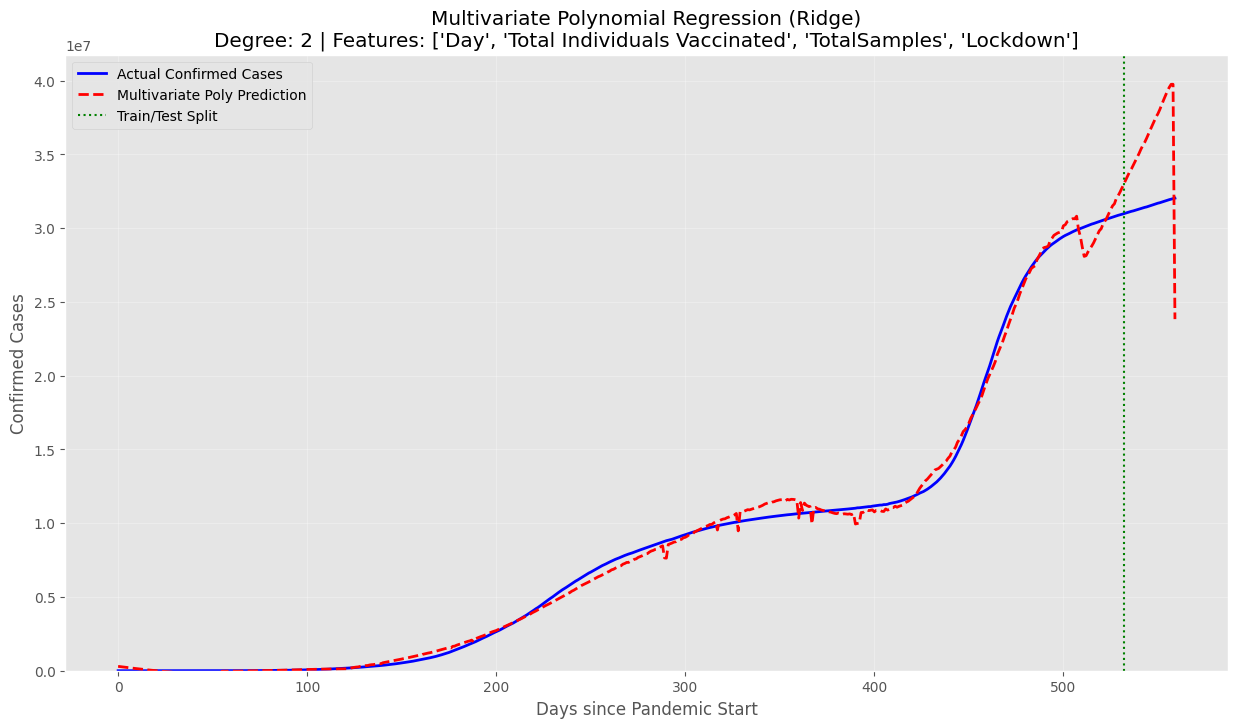

In [5]:
# 1. Predict on Test Data
y_pred_test = model.predict(X_test)

# 2. Predict on FULL Timeline (for plotting)
y_pred_all = model.predict(master_df[feature_cols])

# 3. Accuracy Score
r2 = r2_score(y_test, y_pred_test)
print(f"R2 Score on Test Data: {r2:.4f}")

# 4. Plotting
plt.figure(figsize=(15, 8))

# Actual Data
plt.plot(master_df['Day'], master_df['Confirmed'], color='blue', linewidth=2, label='Actual Confirmed Cases')

# Model Prediction
plt.plot(master_df['Day'], y_pred_all, color='red', linestyle='--', linewidth=2, label='Multivariate Poly Prediction')

# Highlight Split
plt.axvline(x=split_idx, color='green', linestyle=':', label='Train/Test Split')

# Title & Labels
plt.title(f'Multivariate Polynomial Regression (Ridge)\nDegree: {poly_degree} | Features: {feature_cols}')
plt.xlabel('Days since Pandemic Start')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.grid(True, alpha=0.3)

# Limit Y-axis to prevent showing extreme negative values if they still exist
plt.ylim(bottom=0) 

plt.show()